In [ ]:
%%capture
!pip install pymatgen pybtex retrying  # install requirements to query sample data
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu102.html  # install torch scatter for aviary
!pip install -U git+https://github.com/CompRhys/aviary.git  # install aviary
!pip install ml_matrics  # install ml matric for ptable plot

In [ ]:
import pandas as pd
from pymatgen.ext.optimade import OptimadeRester

In [ ]:
opt = OptimadeRester(["mp",])
results = opt.get_structures(elements=["N"], nelements=2)

mp: 100%|██████████| 892/892 [00:11<00:00, 76.94it/s]


In [ ]:
from aviary.wren.utils import get_aflow_label_spglib, count_wyks

df = pd.DataFrame(results)

df.rename(columns={"mp": "final_structure"}, inplace=True)
df["composition"] = df["final_structure"].apply(lambda x: x.composition.reduced_formula)
df["volume_per_atom"] = df["final_structure"].apply(lambda x: x.volume/len(x))
df["wyckoff"] = df["final_structure"].apply(get_aflow_label_spglib)

df = df[df["wyckoff"].apply(count_wyks) < 16]
df = df[df["final_structure"].apply(len) < 64]
df = df[df["volume_per_atom"] < 500]

df.index.name = "material_id"
df.reset_index(inplace=True)

In [ ]:
df

,material_id,final_structure,composition,volume_per_atom,wyckoff
0,mp-1001,"[[-1.29338429 4.107647 1.7712985 ] Ba, [1....",BaN2,19.222909,AB2_mC12_15_e_f:Ba-N
1,mp-1001117,"[[-1.52774448 0.88436646 -3.91648634] Mn, [-1...",Mn3N2,9.488409,A3B2_hP5_164_ad_d:Mn-N
2,mp-1001826,"[[0. 0. 0.] V, [1.1097815 1.1097815 1.1097815] N]",VN,10.934588,AB_cF8_216_a_c:N-V
3,mp-1001828,"[[0. 0. 0.] W, [1.1684905 1.1684905 1.1684905] N]",WN,12.763375,AB_cF8_216_a_c:N-W
4,mp-1001834,"[[0. 0. 0.] Hf, [1.408088 1.408088 1.408088] N]",HfN,11.167331,AB_cP2_221_a_b:Hf-N
...,...,...,...,...,...
777,mvc-15384,"[[1.95401927 2.98045311 5.72197092] Sb, [0.300...",SbN,19.447344,AB_aP4_1_2a_2a:N-Sb
778,mvc-15387,"[[1.76517355 2.85579204 2.08179 ] W, [0.3314...",WN,10.325891,AB_oP4_31_a_a:N-W
779,mvc-15427,[[-7.69503945e-17 7.68182177e+00 2.44495698e...,WN2,12.775456,A2B_mC12_12_2i_i:N-W
780,mvc-15478,"[[2.3848522 0.05759063 3.57463575] Co, [ 2.38...",CoN,13.518407,AB_oC8_40_b_b:Co-N


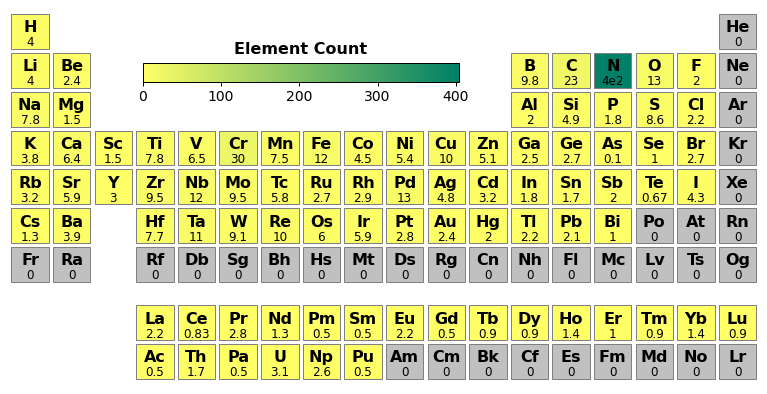

In [ ]:
from ml_matrics.elements import ptable_heatmap

ptable_heatmap(df.composition, log=True)

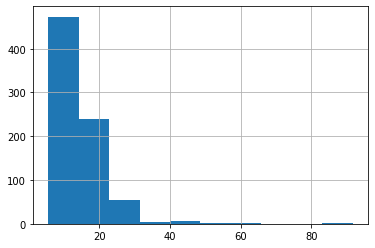

In [ ]:
df.volume_per_atom.hist()

In [ ]:
import os 
import numpy as np
import torch
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split as split

from aviary.utils import results_multitask, train_ensemble

In [ ]:
resume = False
fine_tune = None
transfer = None

optim = "AdamW"
learning_rate = 3e-4
momentum = 0.9
weight_decay = 1e-6
batch_size = 128
workers = 0  
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

targets = ["volume_per_atom"]
tasks = ["regression"]
losses = ["L1"]
robust = True

data_seed = 42
test_size = 0.2
sample = 1

ensemble = 1
run_id = 1
epochs = 100
log = False

# NOTE setting workers to zero means that the data is loaded in the main
# process and enables caching

data_params = {
    "batch_size": batch_size,
    "num_workers": workers,
    "pin_memory": False,
    "shuffle": True,
}

setup_params = {
    "optim": optim,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "momentum": momentum,
    "device": device,
}

restart_params = {
    "resume": resume,
    "fine_tune": fine_tune,
    "transfer": transfer,
}

task_dict = dict(zip(targets, tasks))
loss_dict = dict(zip(targets, losses))

In [ ]:
from aviary.wren.data import WyckoffData, collate_batch as wren_cb
from aviary.wren.model import Wren

torch.manual_seed(0)  # ensure reproducible results

elem_emb = "matscholar200"
sym_emb = "bra-alg-off"
model_name = "wren-reg-test"

data_params["collate_fn"] = wren_cb
data_params["shuffle"] = True 

dataset = WyckoffData(
    df=df,
    elem_emb=elem_emb,
    sym_emb=sym_emb,
    task_dict=task_dict
)
n_targets = dataset.n_targets
elem_emb_len = dataset.elem_emb_len
sym_emb_len = dataset.sym_emb_len

train_idx = list(range(len(dataset)))

print(f"using {test_size} of training set as test set")
train_idx, test_idx = split(train_idx, random_state=data_seed, test_size=test_size)
test_set = torch.utils.data.Subset(dataset, test_idx)

print("No validation set used, using test set for evaluation purposes")
# NOTE that when using this option care must be taken not to
# peak at the test-set. The only valid model to use is the one
# obtained after the final epoch where the epoch count is
# decided in advance of the experiment.
val_set = test_set

train_set = torch.utils.data.Subset(dataset, train_idx[0::sample])

model_params = {
    "task_dict": task_dict,
    "robust": robust,
    "n_targets": n_targets,
    "elem_emb_len": elem_emb_len,
    "elem_fea_len": 32,
    "sym_emb_len": sym_emb_len,
    "sym_fea_len": 32,
    "n_graph": 3,
    "elem_heads": 1,
    "elem_gate": [256],
    "elem_msg": [256],
    "cry_heads": 1,
    "cry_gate": [256],
    "cry_msg": [256],
    "trunk_hidden": [128, 128],
    "out_hidden": [64, 64],
}

os.makedirs(f"models/{model_name}", exist_ok=True)
os.makedirs(f"results/{model_name}", exist_ok=True)

train_ensemble(
    model_class=Wren,
    model_name=model_name,
    run_id=run_id,
    ensemble_folds=ensemble,
    epochs=epochs,
    train_set=train_set,
    val_set=val_set,
    log=log,
    data_params=data_params,
    setup_params=setup_params,
    restart_params=restart_params,
    model_params=model_params,
    loss_dict=loss_dict,
)

data_params["shuffle"] = False  # need fixed data order due to ensembling

roost_results_dict = results_multitask(
    model_class=Wren,
    model_name=model_name,
    run_id=run_id,
    ensemble_folds=ensemble,
    test_set=test_set,
    data_params=data_params,
    robust=robust,
    task_dict=task_dict,
    device=device,
    eval_type="checkpoint",
    save_results=False,
)


using 0.2 of training set as test set
No validation set used, using test set for evaluation purposes
Total Number of Trainable Parameters: 364,522
Dummy MAE: 4.4372
Getting Validation Baseline


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Baseline - volume_per_atom: MAE 5.055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [1/100]
Train 		: volume_per_atom - Loss 1.016	MAE 4.538	RMSE 6.332	
Validation 	: volume_per_atom - Loss 1.119	MAE 5.022	RMSE 10.286	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [2/100]
Train 		: volume_per_atom - Loss 1.006	MAE 4.497	RMSE 6.325	
Validation 	: volume_per_atom - Loss 1.113	MAE 4.992	RMSE 10.295	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [3/100]
Train 		: volume_per_atom - Loss 0.998	MAE 4.458	RMSE 6.320	
Validation 	: volume_per_atom - Loss 1.107	MAE 4.965	RMSE 10.306	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [4/100]
Train 		: volume_per_atom - Loss 0.989	MAE 4.421	RMSE 6.318	
Validation 	: volume_per_atom - Loss 1.101	MAE 4.937	RMSE 10.319	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [5/100]
Train 		: volume_per_atom - Loss 0.981	MAE 4.386	RMSE 6.320	
Validation 	: volume_per_atom - Loss 1.095	MAE 4.909	RMSE 10.335	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [6/100]
Train 		: volume_per_atom - Loss 0.973	MAE 4.352	RMSE 6.325	
Validation 	: volume_per_atom - Loss 1.090	MAE 4.887	RMSE 10.354	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [7/100]
Train 		: volume_per_atom - Loss 0.966	MAE 4.321	RMSE 6.334	
Validation 	: volume_per_atom - Loss 1.086	MAE 4.869	RMSE 10.376	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [8/100]
Train 		: volume_per_atom - Loss 0.959	MAE 4.291	RMSE 6.348	
Validation 	: volume_per_atom - Loss 1.083	MAE 4.852	RMSE 10.402	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [9/100]
Train 		: volume_per_atom - Loss 0.952	MAE 4.263	RMSE 6.366	
Validation 	: volume_per_atom - Loss 1.080	MAE 4.840	RMSE 10.432	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [10/100]
Train 		: volume_per_atom - Loss 0.946	MAE 4.238	RMSE 6.391	
Validation 	: volume_per_atom - Loss 1.079	MAE 4.831	RMSE 10.467	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [11/100]
Train 		: volume_per_atom - Loss 0.940	MAE 4.215	RMSE 6.421	
Validation 	: volume_per_atom - Loss 1.078	MAE 4.823	RMSE 10.507	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [12/100]
Train 		: volume_per_atom - Loss 0.934	MAE 4.193	RMSE 6.458	
Validation 	: volume_per_atom - Loss 1.079	MAE 4.825	RMSE 10.549	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [13/100]
Train 		: volume_per_atom - Loss 0.930	MAE 4.177	RMSE 6.498	
Validation 	: volume_per_atom - Loss 1.081	MAE 4.834	RMSE 10.590	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [14/100]
Train 		: volume_per_atom - Loss 0.926	MAE 4.167	RMSE 6.540	
Validation 	: volume_per_atom - Loss 1.082	MAE 4.842	RMSE 10.623	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [15/100]
Train 		: volume_per_atom - Loss 0.922	MAE 4.161	RMSE 6.572	
Validation 	: volume_per_atom - Loss 1.084	MAE 4.849	RMSE 10.645	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [16/100]
Train 		: volume_per_atom - Loss 0.917	MAE 4.155	RMSE 6.590	
Validation 	: volume_per_atom - Loss 1.084	MAE 4.848	RMSE 10.650	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [17/100]
Train 		: volume_per_atom - Loss 0.911	MAE 4.143	RMSE 6.590	
Validation 	: volume_per_atom - Loss 1.081	MAE 4.837	RMSE 10.641	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [18/100]
Train 		: volume_per_atom - Loss 0.903	MAE 4.128	RMSE 6.574	
Validation 	: volume_per_atom - Loss 1.077	MAE 4.820	RMSE 10.620	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [19/100]
Train 		: volume_per_atom - Loss 0.895	MAE 4.108	RMSE 6.543	
Validation 	: volume_per_atom - Loss 1.071	MAE 4.800	RMSE 10.591	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [20/100]
Train 		: volume_per_atom - Loss 0.885	MAE 4.086	RMSE 6.504	
Validation 	: volume_per_atom - Loss 1.063	MAE 4.778	RMSE 10.560	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [21/100]
Train 		: volume_per_atom - Loss 0.875	MAE 4.064	RMSE 6.462	
Validation 	: volume_per_atom - Loss 1.056	MAE 4.757	RMSE 10.532	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [22/100]
Train 		: volume_per_atom - Loss 0.865	MAE 4.040	RMSE 6.423	
Validation 	: volume_per_atom - Loss 1.048	MAE 4.736	RMSE 10.509	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [23/100]
Train 		: volume_per_atom - Loss 0.853	MAE 4.014	RMSE 6.391	
Validation 	: volume_per_atom - Loss 1.039	MAE 4.715	RMSE 10.489	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [24/100]
Train 		: volume_per_atom - Loss 0.841	MAE 3.988	RMSE 6.362	
Validation 	: volume_per_atom - Loss 1.031	MAE 4.698	RMSE 10.470	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [25/100]
Train 		: volume_per_atom - Loss 0.827	MAE 3.962	RMSE 6.336	
Validation 	: volume_per_atom - Loss 1.023	MAE 4.685	RMSE 10.452	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [26/100]
Train 		: volume_per_atom - Loss 0.814	MAE 3.939	RMSE 6.311	
Validation 	: volume_per_atom - Loss 1.012	MAE 4.666	RMSE 10.420	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [27/100]
Train 		: volume_per_atom - Loss 0.802	MAE 3.918	RMSE 6.272	
Validation 	: volume_per_atom - Loss 0.997	MAE 4.637	RMSE 10.371	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [28/100]
Train 		: volume_per_atom - Loss 0.789	MAE 3.891	RMSE 6.216	
Validation 	: volume_per_atom - Loss 0.983	MAE 4.616	RMSE 10.323	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [29/100]
Train 		: volume_per_atom - Loss 0.777	MAE 3.869	RMSE 6.159	
Validation 	: volume_per_atom - Loss 0.976	MAE 4.607	RMSE 10.290	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [30/100]
Train 		: volume_per_atom - Loss 0.764	MAE 3.848	RMSE 6.115	
Validation 	: volume_per_atom - Loss 0.973	MAE 4.603	RMSE 10.262	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [31/100]
Train 		: volume_per_atom - Loss 0.750	MAE 3.826	RMSE 6.078	
Validation 	: volume_per_atom - Loss 0.970	MAE 4.603	RMSE 10.236	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [32/100]
Train 		: volume_per_atom - Loss 0.734	MAE 3.799	RMSE 6.044	
Validation 	: volume_per_atom - Loss 0.967	MAE 4.598	RMSE 10.209	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [33/100]
Train 		: volume_per_atom - Loss 0.716	MAE 3.767	RMSE 6.008	
Validation 	: volume_per_atom - Loss 0.952	MAE 4.575	RMSE 10.167	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [34/100]
Train 		: volume_per_atom - Loss 0.697	MAE 3.726	RMSE 5.954	
Validation 	: volume_per_atom - Loss 0.949	MAE 4.571	RMSE 10.149	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [35/100]
Train 		: volume_per_atom - Loss 0.676	MAE 3.688	RMSE 5.927	
Validation 	: volume_per_atom - Loss 0.931	MAE 4.547	RMSE 10.110	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [36/100]
Train 		: volume_per_atom - Loss 0.654	MAE 3.641	RMSE 5.874	
Validation 	: volume_per_atom - Loss 0.916	MAE 4.528	RMSE 10.084	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [37/100]
Train 		: volume_per_atom - Loss 0.631	MAE 3.596	RMSE 5.835	
Validation 	: volume_per_atom - Loss 0.892	MAE 4.495	RMSE 10.049	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [38/100]
Train 		: volume_per_atom - Loss 0.608	MAE 3.546	RMSE 5.781	
Validation 	: volume_per_atom - Loss 0.887	MAE 4.485	RMSE 10.031	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [39/100]
Train 		: volume_per_atom - Loss 0.587	MAE 3.504	RMSE 5.753	
Validation 	: volume_per_atom - Loss 0.854	MAE 4.442	RMSE 9.978	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [40/100]
Train 		: volume_per_atom - Loss 0.578	MAE 3.459	RMSE 5.680	
Validation 	: volume_per_atom - Loss 0.870	MAE 4.451	RMSE 9.991	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [41/100]
Train 		: volume_per_atom - Loss 0.561	MAE 3.436	RMSE 5.694	
Validation 	: volume_per_atom - Loss 0.835	MAE 4.408	RMSE 9.947	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [42/100]
Train 		: volume_per_atom - Loss 0.534	MAE 3.381	RMSE 5.629	
Validation 	: volume_per_atom - Loss 0.821	MAE 4.389	RMSE 9.908	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [43/100]
Train 		: volume_per_atom - Loss 0.531	MAE 3.354	RMSE 5.569	
Validation 	: volume_per_atom - Loss 0.823	MAE 4.390	RMSE 9.911	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [44/100]
Train 		: volume_per_atom - Loss 0.509	MAE 3.326	RMSE 5.554	
Validation 	: volume_per_atom - Loss 0.808	MAE 4.362	RMSE 9.881	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [45/100]
Train 		: volume_per_atom - Loss 0.492	MAE 3.282	RMSE 5.491	
Validation 	: volume_per_atom - Loss 0.800	MAE 4.339	RMSE 9.844	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [46/100]
Train 		: volume_per_atom - Loss 0.487	MAE 3.248	RMSE 5.414	
Validation 	: volume_per_atom - Loss 0.818	MAE 4.351	RMSE 9.860	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [47/100]
Train 		: volume_per_atom - Loss 0.480	MAE 3.235	RMSE 5.398	
Validation 	: volume_per_atom - Loss 0.795	MAE 4.317	RMSE 9.813	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [48/100]
Train 		: volume_per_atom - Loss 0.462	MAE 3.182	RMSE 5.310	
Validation 	: volume_per_atom - Loss 0.793	MAE 4.307	RMSE 9.803	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [49/100]
Train 		: volume_per_atom - Loss 0.451	MAE 3.152	RMSE 5.267	
Validation 	: volume_per_atom - Loss 0.818	MAE 4.313	RMSE 9.839	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [50/100]
Train 		: volume_per_atom - Loss 0.443	MAE 3.140	RMSE 5.269	
Validation 	: volume_per_atom - Loss 0.792	MAE 4.284	RMSE 9.802	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [51/100]
Train 		: volume_per_atom - Loss 0.422	MAE 3.090	RMSE 5.202	
Validation 	: volume_per_atom - Loss 0.793	MAE 4.281	RMSE 9.795	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [52/100]
Train 		: volume_per_atom - Loss 0.417	MAE 3.068	RMSE 5.166	
Validation 	: volume_per_atom - Loss 0.841	MAE 4.303	RMSE 9.859	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [53/100]
Train 		: volume_per_atom - Loss 0.408	MAE 3.061	RMSE 5.185	
Validation 	: volume_per_atom - Loss 0.803	MAE 4.264	RMSE 9.810	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [54/100]
Train 		: volume_per_atom - Loss 0.389	MAE 3.011	RMSE 5.110	
Validation 	: volume_per_atom - Loss 0.807	MAE 4.257	RMSE 9.811	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [55/100]
Train 		: volume_per_atom - Loss 0.376	MAE 2.982	RMSE 5.075	
Validation 	: volume_per_atom - Loss 0.852	MAE 4.279	RMSE 9.865	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [56/100]
Train 		: volume_per_atom - Loss 0.368	MAE 2.974	RMSE 5.081	
Validation 	: volume_per_atom - Loss 0.819	MAE 4.247	RMSE 9.813	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [57/100]
Train 		: volume_per_atom - Loss 0.346	MAE 2.922	RMSE 5.007	
Validation 	: volume_per_atom - Loss 0.827	MAE 4.246	RMSE 9.813	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [58/100]
Train 		: volume_per_atom - Loss 0.332	MAE 2.894	RMSE 4.974	
Validation 	: volume_per_atom - Loss 0.856	MAE 4.252	RMSE 9.838	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [59/100]
Train 		: volume_per_atom - Loss 0.326	MAE 2.880	RMSE 4.959	
Validation 	: volume_per_atom - Loss 0.842	MAE 4.244	RMSE 9.804	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [60/100]
Train 		: volume_per_atom - Loss 0.311	MAE 2.848	RMSE 4.908	
Validation 	: volume_per_atom - Loss 0.873	MAE 4.242	RMSE 9.833	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [61/100]
Train 		: volume_per_atom - Loss 0.298	MAE 2.827	RMSE 4.898	
Validation 	: volume_per_atom - Loss 0.862	MAE 4.233	RMSE 9.804	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [62/100]
Train 		: volume_per_atom - Loss 0.284	MAE 2.796	RMSE 4.852	
Validation 	: volume_per_atom - Loss 0.910	MAE 4.236	RMSE 9.847	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [63/100]
Train 		: volume_per_atom - Loss 0.277	MAE 2.782	RMSE 4.852	
Validation 	: volume_per_atom - Loss 0.869	MAE 4.249	RMSE 9.768	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [64/100]
Train 		: volume_per_atom - Loss 0.292	MAE 2.783	RMSE 4.782	
Validation 	: volume_per_atom - Loss 0.950	MAE 4.224	RMSE 9.875	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [65/100]
Train 		: volume_per_atom - Loss 0.267	MAE 2.753	RMSE 4.822	
Validation 	: volume_per_atom - Loss 0.881	MAE 4.206	RMSE 9.785	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [66/100]
Train 		: volume_per_atom - Loss 0.256	MAE 2.716	RMSE 4.741	
Validation 	: volume_per_atom - Loss 0.902	MAE 4.163	RMSE 9.832	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [67/100]
Train 		: volume_per_atom - Loss 0.224	MAE 2.677	RMSE 4.750	
Validation 	: volume_per_atom - Loss 0.961	MAE 4.172	RMSE 9.886	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [68/100]
Train 		: volume_per_atom - Loss 0.240	MAE 2.693	RMSE 4.780	
Validation 	: volume_per_atom - Loss 0.877	MAE 4.171	RMSE 9.742	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [69/100]
Train 		: volume_per_atom - Loss 0.251	MAE 2.673	RMSE 4.665	
Validation 	: volume_per_atom - Loss 0.883	MAE 4.125	RMSE 9.776	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [70/100]
Train 		: volume_per_atom - Loss 0.200	MAE 2.608	RMSE 4.653	
Validation 	: volume_per_atom - Loss 1.067	MAE 4.202	RMSE 9.928	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [71/100]
Train 		: volume_per_atom - Loss 0.312	MAE 2.722	RMSE 4.769	
Validation 	: volume_per_atom - Loss 0.867	MAE 4.141	RMSE 9.707	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [72/100]
Train 		: volume_per_atom - Loss 0.220	MAE 2.604	RMSE 4.571	
Validation 	: volume_per_atom - Loss 0.870	MAE 4.169	RMSE 9.676	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [73/100]
Train 		: volume_per_atom - Loss 0.248	MAE 2.623	RMSE 4.541	
Validation 	: volume_per_atom - Loss 0.896	MAE 4.071	RMSE 9.792	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [74/100]
Train 		: volume_per_atom - Loss 0.169	MAE 2.523	RMSE 4.584	
Validation 	: volume_per_atom - Loss 0.992	MAE 4.110	RMSE 9.871	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [75/100]
Train 		: volume_per_atom - Loss 0.229	MAE 2.592	RMSE 4.647	
Validation 	: volume_per_atom - Loss 0.869	MAE 4.059	RMSE 9.723	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [76/100]
Train 		: volume_per_atom - Loss 0.157	MAE 2.470	RMSE 4.482	
Validation 	: volume_per_atom - Loss 0.886	MAE 4.114	RMSE 9.676	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [77/100]
Train 		: volume_per_atom - Loss 0.187	MAE 2.485	RMSE 4.425	
Validation 	: volume_per_atom - Loss 0.901	MAE 4.029	RMSE 9.732	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [78/100]
Train 		: volume_per_atom - Loss 0.133	MAE 2.416	RMSE 4.435	
Validation 	: volume_per_atom - Loss 1.001	MAE 4.036	RMSE 9.812	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [79/100]
Train 		: volume_per_atom - Loss 0.167	MAE 2.454	RMSE 4.494	
Validation 	: volume_per_atom - Loss 0.934	MAE 4.021	RMSE 9.709	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [80/100]
Train 		: volume_per_atom - Loss 0.110	MAE 2.354	RMSE 4.360	
Validation 	: volume_per_atom - Loss 0.936	MAE 4.090	RMSE 9.633	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [81/100]
Train 		: volume_per_atom - Loss 0.139	MAE 2.369	RMSE 4.275	
Validation 	: volume_per_atom - Loss 0.954	MAE 4.005	RMSE 9.665	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [82/100]
Train 		: volume_per_atom - Loss 0.087	MAE 2.296	RMSE 4.293	
Validation 	: volume_per_atom - Loss 1.041	MAE 3.983	RMSE 9.732	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [83/100]
Train 		: volume_per_atom - Loss 0.120	MAE 2.337	RMSE 4.372	
Validation 	: volume_per_atom - Loss 0.961	MAE 3.997	RMSE 9.621	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [84/100]
Train 		: volume_per_atom - Loss 0.075	MAE 2.266	RMSE 4.234	
Validation 	: volume_per_atom - Loss 0.965	MAE 4.018	RMSE 9.597	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [85/100]
Train 		: volume_per_atom - Loss 0.083	MAE 2.263	RMSE 4.188	
Validation 	: volume_per_atom - Loss 1.042	MAE 3.971	RMSE 9.691	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [86/100]
Train 		: volume_per_atom - Loss 0.072	MAE 2.246	RMSE 4.262	
Validation 	: volume_per_atom - Loss 1.006	MAE 3.967	RMSE 9.655	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [87/100]
Train 		: volume_per_atom - Loss 0.040	MAE 2.197	RMSE 4.182	
Validation 	: volume_per_atom - Loss 0.981	MAE 4.004	RMSE 9.593	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [88/100]
Train 		: volume_per_atom - Loss 0.060	MAE 2.196	RMSE 4.082	
Validation 	: volume_per_atom - Loss 1.028	MAE 3.932	RMSE 9.674	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [89/100]
Train 		: volume_per_atom - Loss 0.023	MAE 2.152	RMSE 4.138	
Validation 	: volume_per_atom - Loss 1.035	MAE 3.925	RMSE 9.674	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [90/100]
Train 		: volume_per_atom - Loss 0.019	MAE 2.135	RMSE 4.108	
Validation 	: volume_per_atom - Loss 0.981	MAE 3.985	RMSE 9.572	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [91/100]
Train 		: volume_per_atom - Loss 0.039	MAE 2.131	RMSE 3.969	
Validation 	: volume_per_atom - Loss 1.022	MAE 3.945	RMSE 9.639	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [92/100]
Train 		: volume_per_atom - Loss -0.008	MAE 2.068	RMSE 4.002	
Validation 	: volume_per_atom - Loss 1.058	MAE 3.954	RMSE 9.658	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [93/100]
Train 		: volume_per_atom - Loss 0.001	MAE 2.069	RMSE 4.004	
Validation 	: volume_per_atom - Loss 0.995	MAE 4.014	RMSE 9.530	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [94/100]
Train 		: volume_per_atom - Loss 0.043	MAE 2.096	RMSE 3.869	
Validation 	: volume_per_atom - Loss 1.024	MAE 3.938	RMSE 9.607	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [95/100]
Train 		: volume_per_atom - Loss -0.036	MAE 2.009	RMSE 3.917	
Validation 	: volume_per_atom - Loss 1.078	MAE 3.963	RMSE 9.635	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [96/100]
Train 		: volume_per_atom - Loss -0.005	MAE 2.042	RMSE 3.939	
Validation 	: volume_per_atom - Loss 0.980	MAE 4.019	RMSE 9.491	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [97/100]
Train 		: volume_per_atom - Loss 0.033	MAE 2.062	RMSE 3.793	
Validation 	: volume_per_atom - Loss 0.967	MAE 3.944	RMSE 9.531	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [98/100]
Train 		: volume_per_atom - Loss -0.058	MAE 1.951	RMSE 3.790	
Validation 	: volume_per_atom - Loss 1.118	MAE 3.988	RMSE 9.631	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [99/100]
Train 		: volume_per_atom - Loss 0.039	MAE 2.071	RMSE 3.911	
Validation 	: volume_per_atom - Loss 0.942	MAE 3.961	RMSE 9.487	


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: [100/100]
Train 		: volume_per_atom - Loss -0.047	MAE 1.943	RMSE 3.734	
Validation 	: volume_per_atom - Loss 0.941	MAE 3.968	RMSE 9.482	
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
------------Evaluate model on Test Set------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Evaluating Model

Task: 'volume_per_atom' on Test Set
Model Performance Metrics:
R2 Score: 0.1470 
MAE: 3.9683
RMSE: 9.4821
